In [ ]:
from avcv.all import *

# Create merge dataset with the following classes
face, eyes, mouth, food, cigarret, phone

## Update face dataset
1. Loop though images 

In [ ]:
# sh scripts/extract_face.sh train
# sh scripts/extract_face.sh val
# sh scripts/extract_food.sh train
# sh scripts/extract_food.sh val

In [ ]:
mode = 'train'

In [ ]:
thr = 0.3
list_new_categories = ['cigarette', 'food/drink', 'phone', 'face', 'eye', 'mouth']

new_categories = [{'id':i+1, 'name':name} for i, name in enumerate(list_new_categories)]

catname2newcatid = {name:i+1 for i, name in enumerate(list_new_categories)}

# catname2newcatid['right_eye'] = catname2newcatid['left_eye']

In [ ]:
catname2newcatid

{'cigarette': 1, 'food/drink': 2, 'phone': 3, 'face': 4, 'eye': 5, 'mouth': 6}

In [ ]:
catname2newcatid['left_eye'] = catname2newcatid['eye']
catname2newcatid['right_eye'] = catname2newcatid['eye']

### Load prediction 

In [ ]:
cc = CocoDataset(f'../.cache/out_jsons/pred_food_on_{mode}.json', '/data/full-version-vip-pro/DMS_DB_090922/')
ds = cc.gt.dataset
new_anns = []
for ann in ds['annotations']:
    if ann['score'] > thr:
        new_anns.append(ann)
ds['annotations'] = new_anns
cc.gt = AvCOCO(ds)

In [ ]:
print('Num of images', len(cc.gt.imgs))

Num of images 7038


In [ ]:
img_ids_with_annotations = cc.gt.imgToAnns.keys()
print('Num of suspicious image samples', len(img_ids_with_annotations))

Num of suspicious image samples 443


In [ ]:
# for img_id in img_ids_with_annotations:
#     cc.visualize(img_id, show=1)

In [ ]:
categories = [mmcv.load('../.cache/out_jsons/pred_food_on_val.json')['categories'],
                mmcv.load('/data/full-version-vip-pro/annotations/val.json')['categories']]

In [ ]:
old_data = AvCOCO(f'/data/full-version-vip-pro/annotations/{mode}.json')
new_data = dict(
    images=[img for img in old_data.dataset['images'] if not img['id'] in img_ids_with_annotations], annotations=[], categories=new_categories
)
for ann in old_data.anns.values():
    if ann['image_id'] in img_ids_with_annotations: continue
    cat_name = old_data.cats[ann['category_id']]['name']
    new_ann = ann.copy()
    new_ann['category_id'] = catname2newcatid[cat_name]
    new_data['annotations'].append(new_ann)

2022-09-18 16:28:38.942 | INFO     | avcv.coco:visualize:191 - Random visualize img_id=244


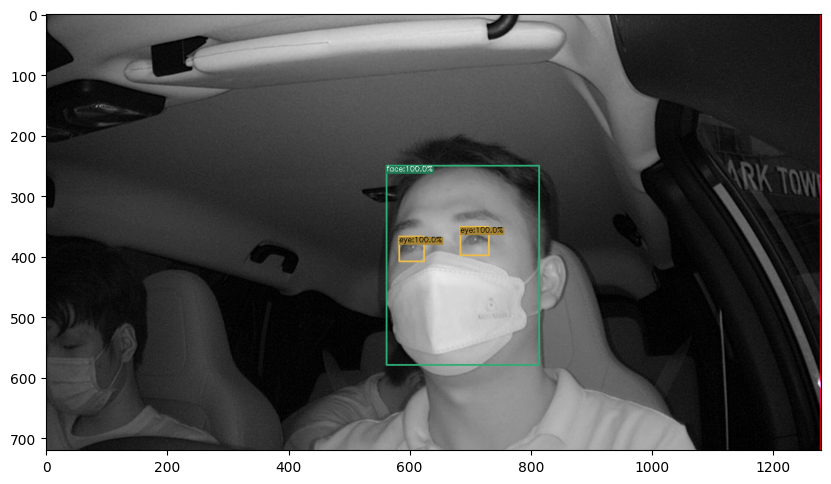

In [ ]:
cc = CocoDataset(new_data, '/data/full-version-vip-pro/DMS_DB_090922/')
cc.visualize(show=1);

In [ ]:
train_ds_1 = new_data.copy()

In [ ]:
print('Num of taken images:', len(new_data['images']))

Num of taken images: 6595


# Update food-cigarret-phone data (add face)

In [ ]:
from fastcore.all import *
class FaceAnalizer:
    def __init__(self, anns, threshold=0.7):
        store_attr('anns,threshold')

    def analize(self):
        face = self.get_face()
        le = self.get_left_eye()
        ry = self.get_right_eye()
        mouth = self.get_mouth()
        
        if face is None:
            return -1
        else:
            c = int(le is not None)+int(re is not None)+int(mouth is not None)
            if c <2 :
                return -2
            else:
                return 1
        
    def get_face(self):
        anns = [ann for ann in self.anns if ann['category_id']==1 if ann['score']>self.threshold]
        anns = list(sorted(anns, key=lambda ann:ann['score']))
        if len(anns):
            return anns[-1]
        return None
    
    def get_left_eye(self):
        anns = [ann for ann in self.anns if ann['category_id'] == 2 if ann['score']>self.threshold]
        anns = list(sorted(anns, key=lambda ann:ann['score']))

        if len(anns):
            return anns[-1]
        return None
    def get_right_eye(self):
        anns = [ann for ann in self.anns if ann['category_id'] == 3 if ann['score']>self.threshold]
        anns = list(sorted(anns, key=lambda ann:ann['score']))

        if len(anns):
            return anns[-1]
        return None
    
    def get_mouth(self):
        anns = [ann for ann in self.anns if ann['category_id'] == 4 if ann['score']>self.threshold]
        anns = list(sorted(anns, key=lambda ann:ann['score']))

        if len(anns):
            return anns[-1]
        return None
        

In [ ]:
cc = CocoDataset(f'../.cache/out_jsons/pred_face_on_{mode}.json', '/data/DMS_Behavior_Detection/images')
ds = cc.gt.dataset
new_anns = []
for ann in ds['annotations']:
    if ann['score'] > thr:
        new_anns.append(ann)
ds['annotations'] = new_anns
cc.gt = AvCOCO(ds)

### Visualize face prediction

2022-09-27 03:59:09.222 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=17739


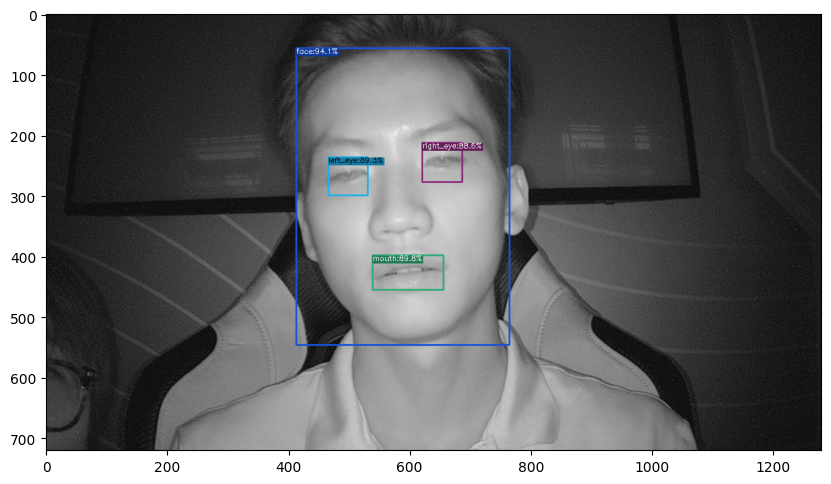

In [ ]:
cc.visualize(show=1);

In [ ]:
face_analize_results = dict()
for img_id in cc.img_ids:
    anns = cc.gt.imgToAnns[img_id]
    face_analize_results[img_id] = FaceAnalizer(anns).analize()
df = pd.DataFrame.from_dict(face_analize_results, orient='index', columns=['fa'])

In [ ]:
ids = df.fa==1
tobe_taken_imgs = ids.index
# print(ids.mean())
# _df = df[ids]
# for img_id, row in _df.iterrows():
#     cc.visualize(img_id, show=1);

In [ ]:
new_categories

[{'id': 1, 'name': 'cigarette'},
 {'id': 2, 'name': 'food/drink'},
 {'id': 3, 'name': 'phone'},
 {'id': 4, 'name': 'face'},
 {'id': 5, 'name': 'eye'},
 {'id': 6, 'name': 'mouth'}]

In [ ]:
old_data = AvCOCO(f'/data/DMS_Behavior_Detection/annotations/food_face_train_27_09_2022.json')
new_data = dict(
    images=[img for img in old_data.dataset['images'] if img['id'] in tobe_taken_imgs], annotations=[], categories=new_categories
)
#update food cigarret phone GT
for ann in old_data.anns.values():
    if ann['image_id'] in tobe_taken_imgs:
        cat_name = old_data.cats[ann['category_id']]['name']
        new_ann = ann.copy()
        new_ann['category_id'] = catname2newcatid[cat_name]
        new_data['annotations'].append(new_ann)
# update face PRED
for ann in cc.gt.anns.values():
    if ann['image_id'] in tobe_taken_imgs:
        cat_name = cc.gt.cats[ann['category_id']]['name']
        new_ann = ann.copy()
        new_ann['category_id'] = catname2newcatid[cat_name]
        new_data['annotations'].append(new_ann)
# update annotation id
for i, ann in enumerate(new_data['annotations']):
    ann['id'] = i

In [ ]:
# cc.img_dir

In [ ]:
# cc = CocoDataset(train_json_out)
vis_imgs = []
for i in range(20):
    vis_imgs.append(cc.visualize(show=0))
    if len(vis_imgs) == 4:
        plot_images(vis_imgs)
        vis_imgs = []

2022-09-27 04:26:07.050 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=27417
2022-09-27 04:26:07.080 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=16110
2022-09-27 04:26:07.098 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=37074
2022-09-27 04:26:07.116 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=38826
2022-09-27 04:26:07.127 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


In [ ]:
train_ds_2 = new_data.copy()

In [ ]:
def concat_coco(datasets, new_root, name):
    """
        Example:
            concat_coco([
                (train_ds_1, '/data/full-version-vip-pro/DMS_DB_090922/'),
                (train_ds_2, '/data/DMS_Behavior_Detection/merge-phone-cigaret-food/images'),

            ], '/data/face_food_concat/', 'train');
        """
    mmcv.mkdir_or_exist(osp.join(new_root, 'annotations'))
    out_concat = dict(
        images=[],
        annotations=[],
    )

    for json_path, old_img_dir in datasets:
        dataset = AvCOCO(json_path)
        # assert check_save_coco_dict(dataset.dataset)
        CocoDataset(json_path, old_img_dir).visualize()
        
        for img_id in dataset.imgs:
            image = dataset.imgs[img_id]
            anns = dataset.imgToAnns[image['id']] if img_id in dataset.imgToAnns else []
            image['id'] = len(out_concat['images'])
            old_path = osp.join(old_img_dir, image['file_name'])
            old_path = osp.abspath(old_path)
            assert osp.exists(old_path), old_path
            image['file_name'] = osp.relpath(old_path, osp.join(new_root, 'images'))
            for ann in anns:
                ann['image_id'] = image['id']
                w,h = ann['bbox'][-2:]
                ann['area'] = w*h
                ann['id'] = len(out_concat['annotations'])
                
                out_concat['annotations'].append(ann)
                
            out_concat['images'].append(image)

    out_concat['categories'] = dataset.dataset['categories']
    mmcv.dump(out_concat, osp.join(new_root,f'annotations/{name}.json'))
    return out_concat

In [ ]:
# concat_coco([
#     (train_ds_1, '/data/full-version-vip-pro/DMS_DB_090922/'),
#     (train_ds_2, '/data/DMS_Behavior_Detection/merge-phone-cigaret-food/images'),
    
# ], '/data/face_food_concat/', mode);

NameError: name 'train_ds_1' is not defined

In [ ]:
data = CocoDataset(f'/data/face_food_concat/annotations/{mode}.json', '/data/face_food_concat/images')

In [ ]:
len(data.gt.imgs)

19334

2022-09-18 16:28:46.121 | INFO     | avcv.coco:visualize:191 - Random visualize img_id=2066


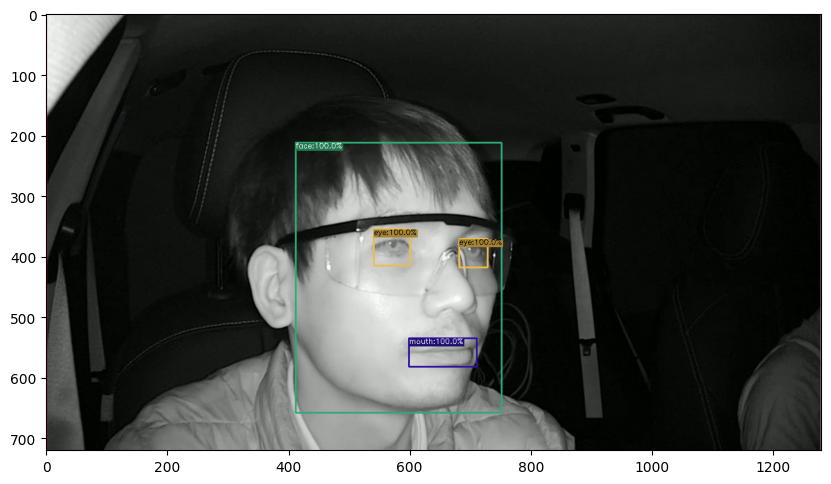

In [ ]:
data.visualize(show=1);